In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
warnings.filterwarnings('ignore')
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


In [ ]:
test =pd.read_csv('/content/data_test_24-29.csv')
train = pd.read_csv('/content/data_train_24-29 (1).csv')



In [ ]:
train_data = train.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)
test_data = test.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)


In [ ]:
train_data.dropna(axis=0, how='any', inplace=True)


In [ ]:
test_data.dropna(axis=0, how='any', inplace=True)
test_data.shape

(44574, 8)

In [ ]:
n_time_steps = 104
n_features = 7 
step = 80
n_classes = 5 
n_epochs = 50       
batch_size = 64   
learning_rate = 0.0001
l2_loss = 0.00015

segments = []
labels = []


In [ ]:
for i in range(0,  train_data.shape[0]- n_time_steps, step):  

    Ax_tr = train_data['Ax'].values[i: i + n_time_steps]

    Ay_tr = train_data['Ay'].values[i: i + n_time_steps]

    Az_tr = train_data['Az'].values[i: i + n_time_steps]

    Gx_tr = train_data['Gx'].values[i: i + n_time_steps]

    Gy_tr = train_data['Gy'].values[i: i + n_time_steps]

    Gz_tr = train_data['Gz'].values[i: i + n_time_steps]

    Speed_tr = train_data['Speed'].values[i: i + n_time_steps]


    label_tr = stats.mode(train_data['Label'][i: i + n_time_steps])[0][0]

    segments.append([Ax_tr, Ay_tr, Az_tr, Gx_tr,Gy_tr,Gz_tr,Speed_tr])

    labels.append(label_tr)

In [ ]:
X_train = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

y_train = np.asarray(pd.get_dummies(labels), dtype = np.float32)

X_train.shape

(2228, 104, 7)

In [ ]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

reshaped_segments.shape

(2228, 104, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.25)


In [ ]:

import os
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


# class Attention(object if debug_flag else Layer):

#     def __init__(self, units=128, **kwargs):
#         super(Attention, self).__init__(**kwargs)
#         self.units = units

#     # noinspection PyAttributeOutsideInit
#     def build(self, input_shape):
#         input_dim = int(input_shape[-1])
#         with K.name_scope(self.name if not debug_flag else 'attention'):
#             self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
#             self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
#             self.attention_score = Dot(axes=[1, 2], name='attention_score')
#             self.attention_weight = Activation('softmax', name='attention_weight')
#             self.context_vector = Dot(axes=[1, 1], name='context_vector')
#             self.attention_output = Concatenate(name='attention_output')
#             self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
#         if not debug_flag:
#             # debug: the call to build() is done in call().
#             super(Attention, self).build(input_shape)

#     def compute_output_shape(self, input_shape):
#         return input_shape[0], self.units

#     def __call__(self, inputs, training=None, **kwargs):
#         if debug_flag:
#             return self.call(inputs, training, **kwargs)
#         else:
#             return super(Attention, self).__call__(inputs, training, **kwargs)

#     # noinspection PyUnusedLocal
#     def call(self, inputs, training=None, **kwargs):
#         """
#         Many-to-one attention mechanism for Keras.
#         @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
#         @param training: not used in this layer.
#         @return: 2D tensor with shape (batch_size, units)
#         @author: felixhao28, philipperemy.
#         """
#         if debug_flag:
#             self.build(inputs.shape)
#         # Inside dense layer
#         #              hidden_states            dot               W            =>           score_first_part
#         # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
#         # W is the trainable weight matrix of attention Luong's multiplicative style score
#         score_first_part = self.attention_score_vec(inputs)
#         #            score_first_part           dot        last_hidden_state     => attention_weights
#         # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
#         h_t = self.h_t(inputs)
#         score = self.attention_score([h_t, score_first_part])
#         attention_weights = self.attention_weight(score)
#         # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
#         context_vector = self.context_vector([inputs, attention_weights])
#         pre_activation = self.attention_output([context_vector, h_t])
#         attention_vector = self.attention_vector(pre_activation)
#         return attention_vector

#     def get_config(self):
#         """
#         Returns the config of a the layer. This is used for saving and loading from a model
#         :return: python dictionary with specs to rebuild layer
#         """
#         config = super(Attention, self).get_config()
#         config.update({'units': self.units})
#         return config


In [ ]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Flatten, Dropout
# from keras.layers import TimeDistributed

# import os
# from tensorflow.keras import Input
# from tensorflow.keras.models import load_model, Model

# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
# # model = Sequential()
# # # RNN layer
# # model.add(LSTM(units = 100, input_shape = (X_train.shape[1], X_train.shape[2])))

# # # Dropout layer
# # model.add(Dropout(0.4))
 
# # # Dense layer with ReLu
# # model.add(Dense(units = 32, activation='tanh'))

# # # Softmax layer
# # model.add(Dense(y_train.shape[1], activation = 'softplus'))

# # # Compile model
# # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # model.summary()
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import TimeDistributed
from keras.layers import Bidirectional

# model = Sequential()
# x = model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
# # model.add(Bidirectional(LSTM(100)))(x)
# x = Attention(units=32)(x)

# x = model.add(Dense(units = 64, activation='tanh'))(x)
# model.add(Dense(y_train.shape[1], activation = 'softplus'))(x)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()
model_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = (Bidirectional(LSTM(100, return_sequences=True,dropout = 0.01)))(model_input)
x = Attention(return_sequences=False)(x) # receive 3D and output 2D
x = Dense(units = 64, activation='tanh')(x)
x = Dense(y_train.shape[1], activation = 'softplus')(x)
model = Model(model_input, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         86400     
 l)                                                              
                                                                 
 attention (Attention)       (None, 200)               304       
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 99,893
Trainable params: 99,893
Non-trainable params: 0
_________________________________________________________

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [ ]:
print(X_test.shape)
print(y_test.shape)

(557, 104, 7)
(557, 5)


In [ ]:
history = model.fit(X_train, y_train, epochs = 80, validation_data = (X_test, y_test), batch_size = 64, verbose = 1)

#history = model.fit(X_train, y_train, epochs = 80, validation_data = (X_test, y_test), batch_size = batch_size, verbose = 1)


Epoch 1/80
27/27 [==============================] - 24s 523ms/step - loss: 0.8197 - accuracy: 0.7983 - val_loss: 0.7803 - val_accuracy: 0.7702
Epoch 2/80
27/27 [==============================] - 11s 411ms/step - loss: 0.6004 - accuracy: 0.8181 - val_loss: 0.5574 - val_accuracy: 0.8187
Epoch 3/80
27/27 [==============================] - 6s 223ms/step - loss: 0.4401 - accuracy: 0.8552 - val_loss: 0.4580 - val_accuracy: 0.8402
Epoch 4/80
27/27 [==============================] - 6s 224ms/step - loss: 0.3803 - accuracy: 0.8743 - val_loss: 0.4084 - val_accuracy: 0.8582
Epoch 5/80
27/27 [==============================] - 6s 221ms/step - loss: 0.3109 - accuracy: 0.8965 - val_loss: 0.3453 - val_accuracy: 0.8995
Epoch 6/80
27/27 [==============================] - 6s 218ms/step - loss: 0.2672 - accuracy: 0.9114 - val_loss: 0.3472 - val_accuracy: 0.8833
Epoch 7/80
27/27 [==============================] - 6s 224ms/step - loss: 0.2224 - accuracy: 0.9246 - val_loss: 0.2779 - val_accuracy: 0.9138
Epoc

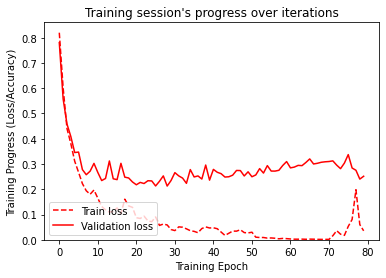

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
# plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
# plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

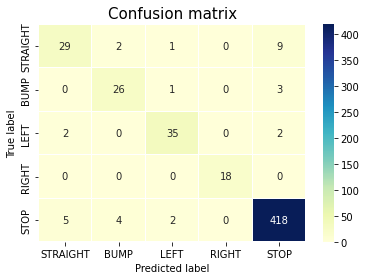

In [ ]:
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = [ 'STRAIGHT', 'BUMP', 'LEFT',  'RIGHT','STOP']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

9/9 [==============================] - 1s 58ms/step - loss: 0.2515 - accuracy: 0.9443
Test Accuracy : 0.944344699382782
Test Loss : 0.25148075819015503


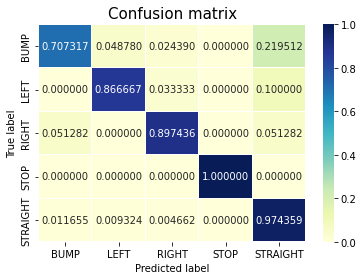

In [ ]:


import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['BUMP', 'LEFT',  'RIGHT','STOP', 'STRAIGHT']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='2f', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()